In [1]:
from skrub.datasets import fetch_employee_salaries

dataset = fetch_employee_salaries()
X, y = dataset.X, dataset.y

X

,gender,department,department_name,division,assignment_category,employee_position_title,date_first_hired,year_first_hired
0,F,POL,Department of Police,MSB Information Mgmt and Tech Division Records...,Fulltime-Regular,Office Services Coordinator,09/22/1986,1986
1,M,POL,Department of Police,ISB Major Crimes Division Fugitive Section,Fulltime-Regular,Master Police Officer,09/12/1988,1988
2,F,HHS,Department of Health and Human Services,Adult Protective and Case Management Services,Fulltime-Regular,Social Worker IV,11/19/1989,1989
3,M,COR,Correction and Rehabilitation,PRRS Facility and Security,Fulltime-Regular,Resident Supervisor II,05/05/2014,2014
4,M,HCA,Department of Housing and Community Affairs,Affordable Housing Programs,Fulltime-Regular,Planning Specialist III,03/05/2007,2007
...,...,...,...,...,...,...,...,...
9223,F,HHS,Department of Health and Human Services,School Based Health Centers,Fulltime-Regular,Community Health Nurse II,11/03/2015,2015
9224,F,FRS,Fire and Rescue Services,Human Resources Division,Fulltime-Regular,Fire/Rescue Division Chief,11/28/1988,1988
9225,M,HHS,Department of Health and Human Services,Child and Adolescent Mental Health Clinic Serv...,Parttime-Regular,Medical Doctor IV - Psychiatrist,04/30/2001,2001
9226,M,CCL,County Council,Council Central Staff,Fulltime-Regular,Manager II,09/05/2006,2006


In [2]:
df = X

In [4]:
X_dirty = X[["employee_position_title"]]

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    CountVectorizer(analyzer="char_wb", ngram_range=(2, 3)), 
)

x_dirty_list = list(X_dirty['employee_position_title'])
X_enc = pipe.fit_transform(x_dirty_list)
X_enc.shape

(9228, 1469)

In [6]:
from sklearn.metrics.pairwise import euclidean_distances

titles = [
 'District Supervisor',
 'Labor Relations Advisor',
 'Land Survey Supervisor',
 'Psychologist Supervisor',
 'Resident Supervisor I',
 'Revenue Counter Supervisor',
 'Senior Architect',
 'Senior Engineer',
 'Senior Investment Analyst',
 'Senior Latent Print Examiner',
 'Senior Retirement Analyst',
 'Supervisor Parking Meter Unit',
 'Warehouse Worker',
 'Work Force Leader IV'
]

dists = euclidean_distances(pipe.transform(["senior software architect"]), pipe.transform(titles))
for d, t in zip(dists[0], titles):
    print(t, d)

District Supervisor 8.366600265340756
Labor Relations Advisor 9.0
Land Survey Supervisor 9.1104335791443
Psychologist Supervisor 8.94427190999916
Resident Supervisor I 8.426149773176359
Revenue Counter Supervisor 9.0
Senior Architect 3.4641016151377544
Senior Engineer 7.0710678118654755
Senior Investment Analyst 8.18535277187245
Senior Latent Print Examiner 8.717797887081348
Senior Retirement Analyst 7.937253933193772
Supervisor Parking Meter Unit 9.055385138137417
Warehouse Worker 7.874007874011811
Work Force Leader IV 8.831760866327848


In [8]:
from sklearn.decomposition import PCA

X_sparse = CountVectorizer(analyzer="char_wb", ngram_range=(2, 4)).fit_transform(x_dirty_list)
pca = PCA(n_components=10, svd_solver='arpack').fit(X_sparse)
pca.transform(X_sparse).shape

(9228, 10)

In [9]:
import numpy as np 

np.abs(pca.inverse_transform(pca.transform(X_sparse)) - X_sparse).sum()

728342.6330410416

In [10]:
data = []
for size in [5, 10, 20, 50, 100, 200, 500, 1000]:
    pca = PCA(n_components=size, svd_solver='arpack').fit(X_sparse)
    data.append({
        'size': size,
        'diff': np.abs(pca.inverse_transform(pca.transform(X_sparse)) - X_sparse).sum(),
    })

In [11]:
import polars as pl 

pl.DataFrame(data).plot.line("size", "diff")

alt.Chart(...)

In [12]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    CountVectorizer(analyzer="char_wb", ngram_range=(2, 4)), 
    PCA(n_components=50, svd_solver='arpack')
)

x_dirty_list = list(X_dirty['employee_position_title'])
X_enc = pipe.fit_transform(x_dirty_list)
X_enc.shape

(9228, 50)

In [13]:
from sklearn.metrics.pairwise import euclidean_distances

titles = [
 'District Supervisor',
 'Labor Relations Advisor',
 'Land Survey Supervisor',
 'Psychologist Supervisor',
 'Resident Supervisor I',
 'Revenue Counter Supervisor',
 'Senior Architect',
 'Senior Engineer',
 'Senior Investment Analyst',
 'Senior Latent Print Examiner',
 'Senior Retirement Analyst',
 'Supervisor Parking Meter Unit',
 'Warehouse Worker',
 'Work Force Leader IV'
]

dists = euclidean_distances(pipe.transform(["distract supervisor"]), pipe.transform(titles))
for d, t in sorted(zip(dists[0], titles), key=lambda d: d[0]):
    print(t, d)

District Supervisor 1.241423832645995
Psychologist Supervisor 2.2697398200782235
Land Survey Supervisor 2.739740192236779
Resident Supervisor I 3.5575262560312835
Supervisor Parking Meter Unit 3.903208572709078
Revenue Counter Supervisor 4.109762866012042
Labor Relations Advisor 5.157679324534353
Senior Architect 6.7793223249805505
Senior Investment Analyst 7.410216378033824
Warehouse Worker 7.726475809802299
Senior Engineer 7.734467322206361
Senior Retirement Analyst 7.755746749920925
Senior Latent Print Examiner 7.784880585822618
Work Force Leader IV 8.115544309613789


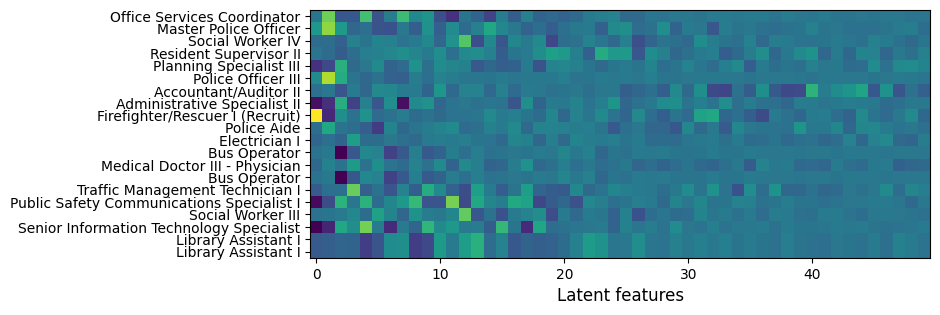

In [14]:
import matplotlib.pyplot as plt

encoded_labels = pipe.transform(x_dirty_list[:20])
plt.figure(figsize=(8, 10))
plt.imshow(encoded_labels)
plt.xlabel("Latent features", size=12)
plt.yticks(range(0, 20), labels=X_dirty[:20].to_numpy().flatten())
plt.show()

In [15]:
from skrub import GapEncoder

enc = GapEncoder(n_components=10, random_state=1)
X_enc = enc.fit_transform(X_dirty)
X_enc.shape

ValueError: ``GapEncoder.fit`` should be passed a single column, not a dataframe. ``GapEncoder`` is a type of single-column transformer. Unlike most scikit-learn estimators, its ``fit``, ``transform`` and ``fit_transform`` methods expect a single column (a pandas or polars Series) rather than a full dataframe. To apply this transformer to one or more columns in a dataframe, use it as a parameter in a ``skrub.TableVectorizer`` or ``sklearn.compose.ColumnTransformer``. In the ``ColumnTransformer``, pass a single column: ``make_column_transformer((GapEncoder(), 'col_name_1'), (GapEncoder(), 'col_name_2'))`` instead of ``make_column_transformer((GapEncoder(), ['col_name_1', 'col_name_2']))``.

In [ ]:
topic_labels = enc.get_feature_names_out(n_labels=3)
for k, labels in enumerate(topic_labels):
    print(f"Topic n°{k}: {labels}")

In [ ]:
import matplotlib.pyplot as plt

subset = X_dirty[20:40]
encoded_labels = enc.transform(subset)
plt.figure(figsize=(8, 10))
plt.imshow(encoded_labels)
plt.xlabel("Latent topics", size=12)
plt.xticks(range(0, 10), labels=topic_labels, rotation=50, ha="right")
plt.ylabel("Data entries", size=12)
plt.yticks(range(0, 20), labels=subset.to_numpy().flatten())
plt.colorbar().set_label(label="Topic activations", size=12)
plt.tight_layout()
plt.show()

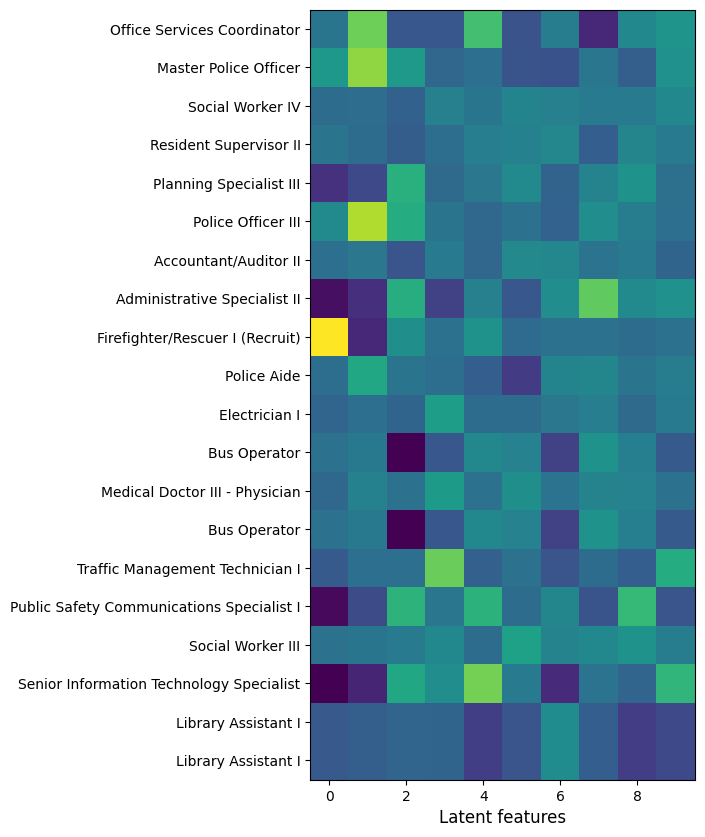

In [9]:
import matplotlib.pyplot as plt

encoded_labels = pipe.transform(x_dirty_list[:20])
plt.figure(figsize=(8, 10))
plt.imshow(encoded_labels)
plt.xlabel("Latent features", size=12)
plt.yticks(range(0, 20), labels=X_dirty[:20].to_numpy().flatten())
plt.show()

So ... it seems that the `GapEncoder` does something "more" here. So let's dive into that. 

Internally the encoder first does the countvectorizer thing where we have a bag of words of size (n_samples, vocab_size). 

But we're going to try to reduce that down to (n_samples, n_components). To do that, we're going to approximate the bag of words representation with a factorization. 

```
BAG_OF_WORDS /approx TOPIC_SAMPLE_MATRIX @ TOPIC_VOCAB_MATRIX
(n, v)               (n, t)                (t, v)
V                    H                      W 
```

You could optimise this with gradient descent, but you could also do something _extra_. 